In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from texas_gerrymandering_hb4.config import FINAL_CSV, CLEAN_DISTRICTS_PARQUET, IMAGES_DIR


In [24]:
import re
import pandas as pd
import geopandas as gpd




df  = pd.read_csv(FINAL_CSV)
gdf = gpd.read_parquet(CLEAN_DISTRICTS_PARQUET)   # if this errors: pip install pyarrow

def candidate_cols(cols):
    pat = re.compile(r"(district(_?id)?|^cd\d*fp$|^cd$|geoid\d*$|geoid$|geocode)", re.I)
    return [c for c in cols if pat.search(c)]

def make_district_id_from_any(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    out = pd.Series(pd.NA, index=s.index, dtype="Int64")

    # TX GEOID like '4807' / '04807' / '4812' → take last 2
    is_tx_geoid = s.str.fullmatch(r"0?48\d{2,3}")
    out.loc[is_tx_geoid] = s[is_tx_geoid].str[-2:].astype(int)

    # 2-digit strings '01'..'38'
    mask_2dig = s.str.fullmatch(r"\d{2}")
    out.loc[mask_2dig & out.isna()] = s[mask_2dig & out.isna()].astype(int)

    # 1–2 digit integers '1'..'38'
    mask_int = s.str.fullmatch(r"\d{1,2}")
    out.loc[mask_int & out.isna()] = s[mask_int & out.isna()].astype(int)

    # Embedded trailing digits: 'CD-07', 'TX07', 'CD118FP=07'
    tail = s.str.extract(r"(\d{1,2})$")
    take = tail[0].notna() & out.isna()
    out.loc[take] = tail.loc[take, 0].astype(int)

    return out.rename("district_id")

def ensure_district_id(frame: pd.DataFrame) -> pd.DataFrame:
    if "district_id" in frame.columns:
        return frame
    for col in (["district_id","district","district_num","district_number",
                 "CD118FP","CD117FP","CD116FP","cd118fp","cd117fp","cd116fp",
                 "CD","cd","GEOID20","GEOID10","GEOID","geoid20","geoid10","geoid"]
                + candidate_cols(frame.columns)):
        if col in frame.columns:
            key = make_district_id_from_any(frame[col])
            if key.dropna().between(1,38).all():
                frame = frame.copy()
                frame["district_id"] = key.astype("Int64")
                return frame
    raise KeyError("Could not infer district_id. Columns seen: " + ", ".join(frame.columns))

df  = ensure_district_id(df)
gdf = ensure_district_id(gdf)

# Sanity checks
assert df["district_id"].between(1,38).all(), "Tabular district_id outside 1..38"
assert gdf["district_id"].between(1,38).all(), "Geo district_id outside 1..38"

# If you expect exactly 1 row per district in both:
dup_df  = df["district_id"].value_counts().loc[lambda s: s>1]
dup_gdf = gdf["district_id"].value_counts().loc[lambda s: s>1]
if not dup_df.empty:
    print("Tabular duplicates; collapsing to one per district by mean:")
    num_cols = df.select_dtypes("number").columns.tolist()
    df = df.groupby("district_id", as_index=False)[num_cols].mean()

if not dup_gdf.empty:
    raise ValueError(f"Geodata has duplicate districts: {dup_gdf.index.tolist()}")

# Merge (no dropping columns) with one-to-one validation
merged = gdf.merge(df, on="district_id", how="left", validate="one_to_one")

print("Merged rows:", len(merged))
missing = set(range(1,39)) - set(merged["district_id"].unique())
print("Missing districts after merge:", sorted(missing))


Merged rows: 38
Missing districts after merge: []


In [25]:
print(df.info())
print(df.describe())

# Missing values
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district_id        38 non-null     int64  
 1   polsby_popper      38 non-null     float64
 2   schwartzberg       38 non-null     float64
 3   convex_hull_ratio  38 non-null     float64
 4   reock              38 non-null     float64
 5   pct_white          38 non-null     float64
 6   pct_black          38 non-null     float64
 7   pct_asian          38 non-null     float64
 8   pct_hispanic       38 non-null     float64
 9   dem_share          38 non-null     float64
 10  rep_share          38 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 3.4 KB
None
       district_id  polsby_popper  schwartzberg  convex_hull_ratio      reock  \
count    38.000000      38.000000     38.000000          38.000000  38.000000   
mean     19.500000       0.221837      0.462684        

In [26]:
df.head()
gdf.head()

,district,area_sq_km,convex_hull_area_sq_km,convex_hull_ratio,perimeter_km,polsby_popper,reock,schwartzberg,geometry,district_id
0,1,24872.423988,34407.648538,0.722875,1270.431901,0.193653,0.410968,0.440061,"POLYGON ((-94.12963 31.09928, -94.13149 31.100...",1
1,2,1310.539397,2095.991145,0.625260,315.656491,0.165284,0.420622,0.406551,"POLYGON ((-95.53725 29.87388, -95.53732 29.877...",2
2,3,8726.001927,10833.559850,0.805460,711.485635,0.216617,0.274956,0.465422,"POLYGON ((-94.70576 32.87916, -94.70579 32.879...",3
3,4,12114.918945,21097.061568,0.574247,1213.041827,0.103462,0.223692,0.321654,"POLYGON ((-96.84412 32.98744, -96.8441 32.9889...",4
4,5,9956.758283,12095.544056,0.823176,823.654724,0.184432,0.312211,0.429456,"POLYGON ((-95.73928 31.50406, -95.7392 31.5041...",5


Text(0.5, 0.98, 'Racial Composition by District')

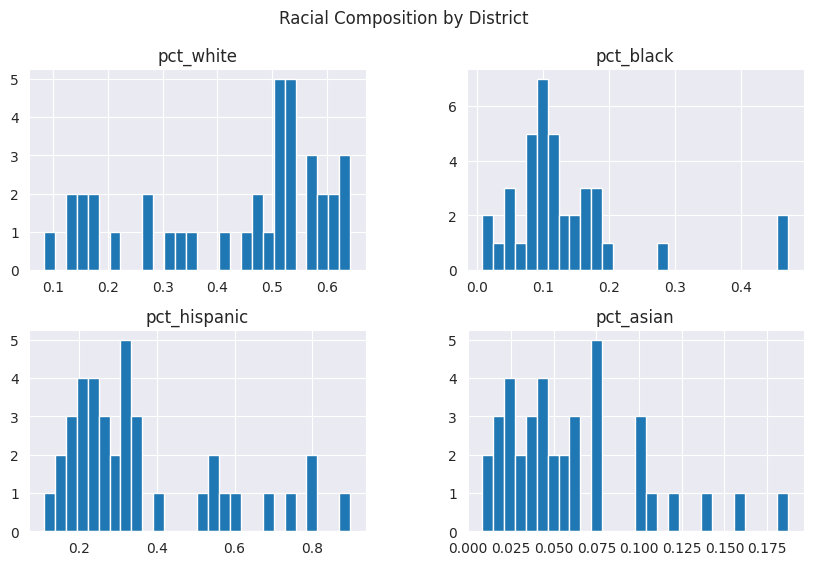

In [27]:
# Racial composition
race_cols = ["pct_white", "pct_black", "pct_hispanic", "pct_asian"]

df[race_cols].hist(bins=28, figsize=(10,6))
plt.suptitle("Racial Composition by District") #scales are different, must configure plot

Text(0.5, 1.0, 'Democratic Vote Share by District')

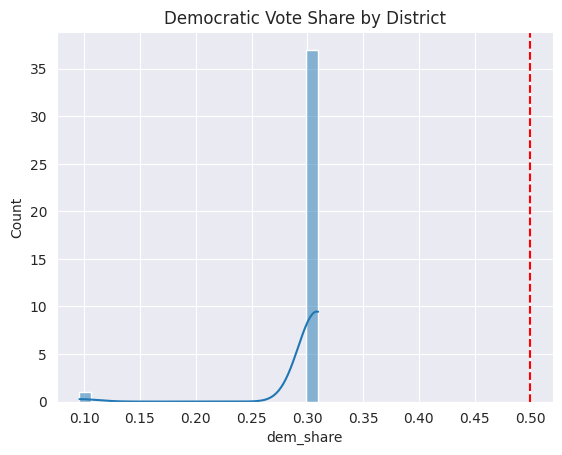

In [28]:
# Party share
sns.histplot(df["dem_share"], bins=20, kde=True)
plt.axvline(0.5, color="red", linestyle="--")
plt.title("Democratic Vote Share by District")

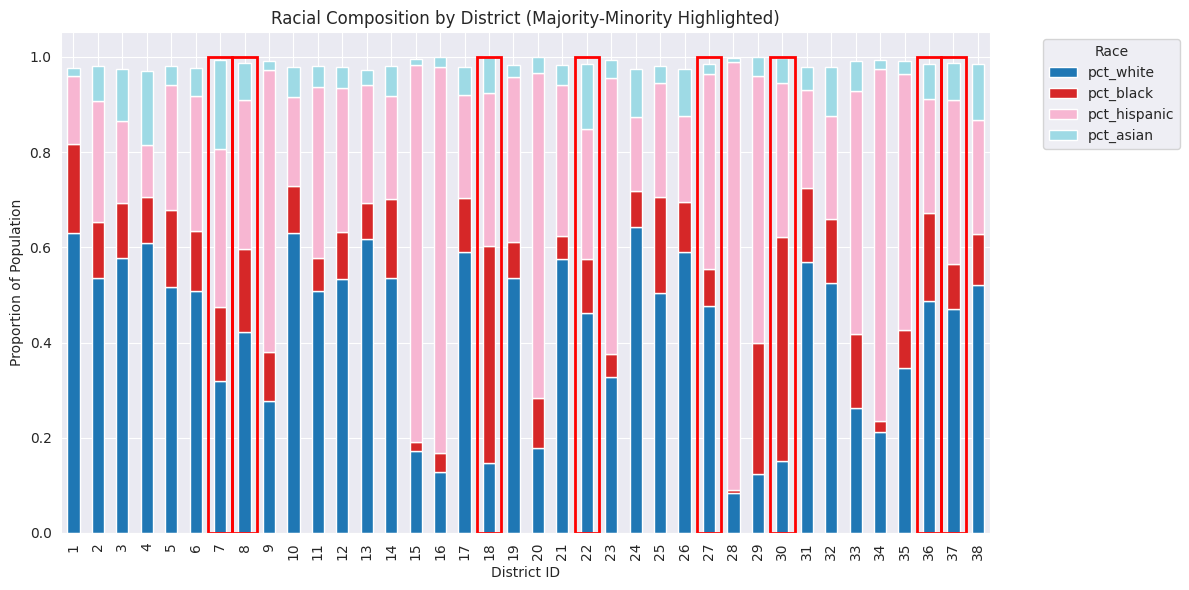

In [29]:
# Determine majority-minority districts
df["max_group_share"] = df[race_cols].max(axis=1)
df["majority_minority"] = df["max_group_share"] < 0.5

# Stacked bar data
df_race = df.set_index("district_id")[race_cols]

# Plot stacked bars
ax = df_race.plot(
    kind="bar", stacked=True, figsize=(12,6), colormap="tab20"
)

# Add rectangle around full bar for majority-minority districts
for idx, is_mm in enumerate(df["majority_minority"]):
    if is_mm:
        # x = bar left edge, width=1, y=0 to height=1
        rect = patches.Rectangle(
            (idx-0.5, 0), 1, 1,  # (x,y), width, height
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)

plt.title("Racial Composition by District (Majority-Minority Highlighted)")
plt.ylabel("Proportion of Population")
plt.xlabel("District ID")
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "stacked_bar_chart.png")

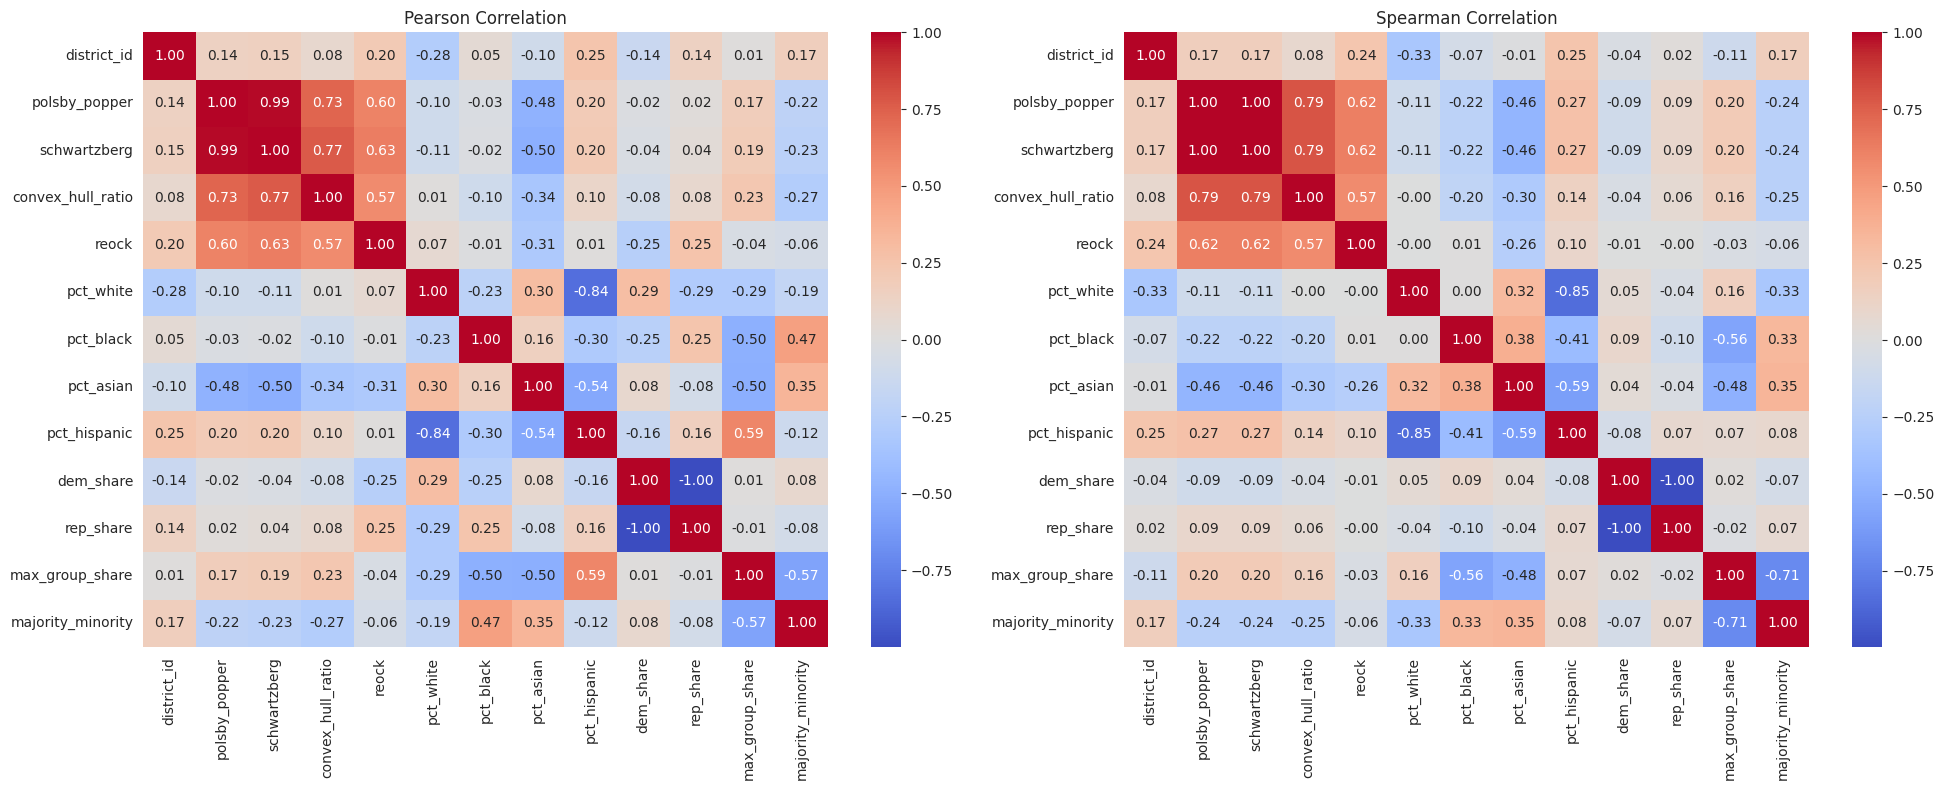

In [30]:
pearson_corr = df.corr(method="pearson")
spearman_corr = df.corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(
    pearson_corr,
    cmap="coolwarm", center=0, annot=True, fmt=".2f",
    ax=axes[0]
)
axes[0].set_title("Pearson Correlation")

sns.heatmap(
    spearman_corr,
    cmap="coolwarm", center=0, annot=True, fmt=".2f",
    ax=axes[1]
)
axes[1].set_title("Spearman Correlation")

plt.tight_layout()
plt.savefig(IMAGES_DIR / "correlation_matricies.png")


Text(0.5, 1.0, '% Latino vs Democratic Vote Share')

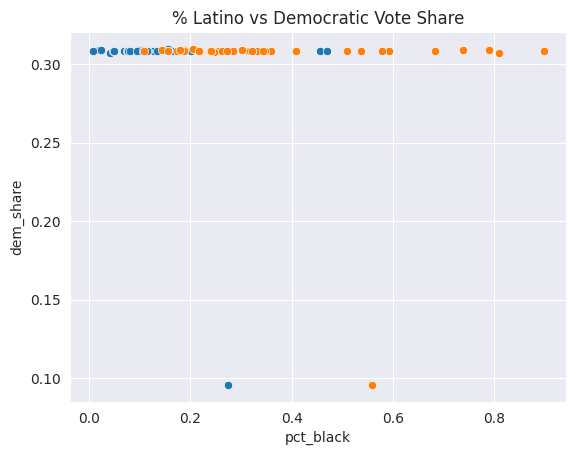

In [31]:
sns.scatterplot(data=df, x="pct_black", y="dem_share")
plt.title("% Black vs Democratic Vote Share")

sns.scatterplot(data=df, x="pct_hispanic", y="dem_share")
plt.title("% Latino vs Democratic Vote Share")


    district_id     reock  dem_share
31           32  0.165108   0.308558
14           15  0.172145   0.308854
13           14  0.180084   0.308610
6             7  0.183883   0.308623
10           11  0.205052   0.308562


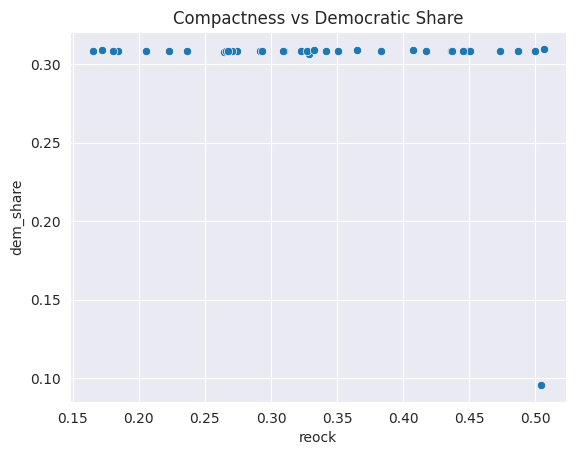

In [32]:
sns.scatterplot(data=df, x="reock", y="dem_share")
plt.title("Compactness vs Democratic Share")

# Find lowest compactness districts
print(df.nsmallest(5, "reock")[["district_id", "reock", "dem_share"]])


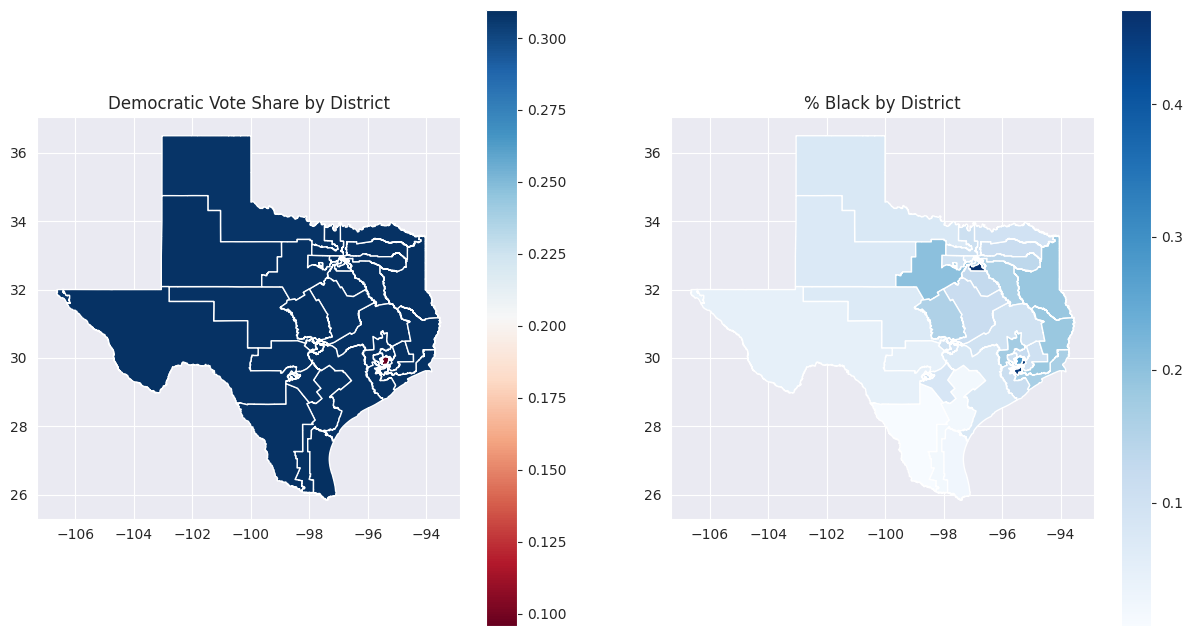

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

merged.plot(column="dem_share", cmap="RdBu", legend=True, ax=ax[0])
ax[0].set_title("Democratic Vote Share by District")

merged.plot(column="pct_black", cmap="Blues", legend=True, ax=ax[1])
ax[1].set_title("% Black by District")

plt.show()


Text(0.5, 1.0, 'ECDF of Democratic Vote Share')

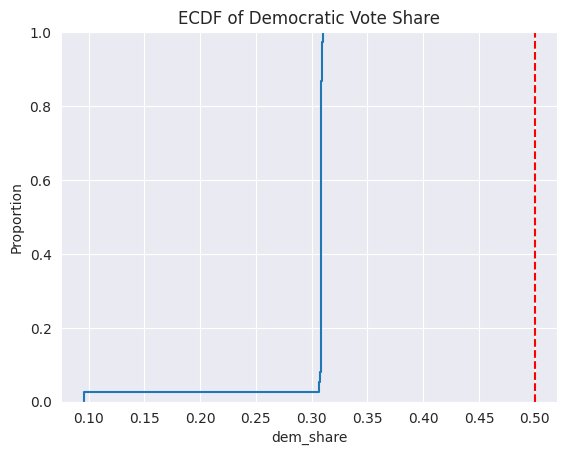

In [34]:
sns.ecdfplot(df["dem_share"])
plt.axvline(0.5, color="red", linestyle="--")
plt.title("ECDF of Democratic Vote Share")
